In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anim

import crocosi.postp as pp
from crocosi.jet import set_relevant_time

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [30]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
#client = Client(cluster) # with distributed cluster

In [3]:
client


Client Scheduler: tcp://127.0.0.1:56010 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


In [4]:
root_path = '/home/datawork-lops-osi/slgentil/croco/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'

In [7]:
path_new = '/home1/datawork/slgentil/jet_cfg1_wp75_4km_1500a2000j_floats_lev50/'

In [43]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=['surf'], 
                chunk_time={'his': 1, 'surf': 1}, grid_params=gparams)

In [46]:
r['surf']

<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, s_rho_slice0: 1, time: 72000, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
    eta_v                (y_v, x_rho) float32 dask.array<chunksize=(721, 258), meta=np.ndarray>
    xi_rho               (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    eta_u                (y_rho, x_u) float32 dask.array<chunksize=(722, 257), meta=np.ndarray>
    xi_u                 (y_rho, x_u) float32 dask.array<chunksize=(722, 257), meta=np.ndarray>
    xi_v                 (y_v, x_rho) float32 dask.array<chunksize=(721, 258), meta=np.ndarray>
    eta_rho              (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
  * s_rho_slice0         (s_rho_slice0) float32 -0.01
    time_instant         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_counter         (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03
    f                    (y_rho, x_rho) float32 dask.ar

In [5]:
#path_data='/Users/zcaspar/jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'
#df = dd.read_csv(glob(root_path+run+'t?/float.????'), 
df = dd.read_csv(glob(root_path+run+'t1/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp','u','v','dudt','dvdt','pres'],
                 delim_whitespace=True)#.persist()
dxy = int(run[run.find('km')-1])
df['x'] = df.xgrid*dxy
df['y'] = df.ygrid*dxy
df = df.persist()
df.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
0,7161,1500.0069,196.40944,541.79652,50.0,-0.935944,25.886666,0.058079,-0.105506,-5.820925e-08,3.420817e-07,-8.260263,785.63776,2167.18608
1,7162,1500.0069,196.40937,543.30184,50.0,-0.940022,25.885229,0.057283,-0.101750,-2.034746e-08,3.515808e-07,-8.300321,785.63748,2173.20736
2,7163,1500.0069,196.40946,544.80716,50.0,-0.944117,25.884374,0.058512,-0.097537,-1.201106e-09,3.599363e-07,-8.340519,785.63784,2179.22864
3,7164,1500.0069,196.40961,546.31250,50.0,-0.948345,25.884627,0.060480,-0.093268,-1.958836e-08,3.627984e-07,-8.381996,785.63844,2185.25000
4,7165,1500.0069,196.40971,547.81780,50.0,-0.952706,25.885603,0.061626,-0.089432,-6.096121e-08,3.575484e-07,-8.424740,785.63884,2191.27120


In [9]:
df1 = dd.read_csv(glob(root_path+run+'t2/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp','X1','X2','X3','X4','X5'],
                 delim_whitespace=True).persist()
df1.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,X1,X2,X3,X4,X5
0,2392,1600.0,202.45459,555.30114,50.0,-0.441719,25.880693,-0.043582,0.085333,0.000006,0.000015,-3.412012
1,2393,1600.0,203.35704,556.39832,50.0,-0.447484,25.882115,-0.021729,0.028096,-0.000005,0.000017,-3.468518
2,2394,1600.0,200.82907,556.26515,50.0,-0.451100,25.883482,-0.091803,0.068287,0.000003,0.000030,-3.503944
3,2395,1600.0,196.52656,555.71030,50.0,-0.447494,25.885577,-0.135628,0.122027,0.000010,0.000038,-3.468491
4,2692,1600.0,195.98028,551.61897,50.0,-0.420034,25.881794,-0.108055,0.283380,0.000037,0.000018,-3.199236


In [11]:
df2 = dd.read_csv(glob(root_path+run+'t3/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp','X1','X2','X3','X4','X5'],
                delim_whitespace=True).persist()
df2.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,X1,X2,X3,X4,X5
0,274,1700.0,228.79740,581.35682,50.0,-0.446967,25.886335,-0.109194,-0.205650,-0.000014,-4.101474e-07,-3.463293
1,275,1700.0,215.95381,581.12501,50.0,-0.433528,25.885475,-0.366684,-0.141488,-0.000009,3.959290e-05,-3.331487
2,276,1700.0,222.63530,585.26013,50.0,-0.423708,25.885130,-0.199095,-0.341237,-0.000042,1.403987e-05,-3.235164
3,277,1700.0,223.09539,584.71844,50.0,-0.424851,25.884756,-0.195507,-0.335283,-0.000042,1.506545e-05,-3.246390
4,278,1700.0,220.63995,583.03578,50.0,-0.434419,25.884849,-0.294566,-0.305988,-0.000039,2.781373e-05,-3.340258


In [20]:
df2 = dd.read_csv(glob(path_new+'t3/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp','X1','X2','X3','X4','X5'],
                delim_whitespace=True).persist()
df2.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,X1,X2,X3,X4,X5
0,194,1700.0,197.31540,554.84405,50.0,-0.344646,25.892402,-0.091033,-0.056985,6.326971e-08,-3.238670e-08,-2.459379
1,250,1700.0,253.84876,550.79545,50.0,-0.555811,25.896888,-0.028089,-0.046005,2.921781e-08,-9.348941e-08,-4.530688
2,251,1700.0,252.38882,551.66698,50.0,-0.551367,25.895246,-0.032966,-0.047567,2.315326e-08,-9.907788e-08,-4.487153
3,252,1700.0,252.72567,550.33823,50.0,-0.553975,25.895848,-0.028406,-0.045600,2.703466e-08,-9.513189e-08,-4.512716
4,253,1700.0,251.61367,551.03201,50.0,-0.550605,25.894686,-0.032281,-0.046830,2.858870e-08,-1.002080e-07,-4.479692


In [7]:
df3 = dd.read_csv(glob(root_path+run+'t4/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp','X1','X2','X3','X4','X5'],
                 delim_whitespace=True).persist()
df3.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,X1,X2,X3,X4,X5
0,210,1800.0,243.98787,543.59693,50.0,-0.509734,25.860048,-0.136270,0.057534,-0.000016,0.000024,-4.080048
1,246,1800.0,214.56437,573.55787,50.0,-0.714727,25.896471,0.200425,-0.002094,-0.000045,-0.000028,-6.089717
2,247,1800.0,225.18302,594.30595,50.0,-0.626867,25.894627,-0.128529,0.409933,0.000033,0.000034,-5.227857
3,248,1800.0,209.87796,565.87639,50.0,-0.754571,25.899651,0.013435,-0.069608,-0.000038,0.000011,-6.480475
4,250,1800.0,233.58084,562.28412,50.0,-0.542508,25.890562,0.322520,0.216019,0.000012,-0.000053,-4.400414


In [36]:
df4 = dd.read_csv(glob(root_path+run+'t5/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp','X1','X2','X3','X4','X5'],
                 delim_whitespace=True).persist()
df4.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,X1,X2,X3,X4,X5
0,227,1900.0,228.12352,548.04469,50.0,-0.566864,25.902031,0.091537,-0.085989,-0.000031,0.000012,-4.638957
1,299,1900.0,231.81830,547.68316,50.0,-0.529797,25.885716,-0.048803,-0.077266,-0.000030,0.000024,-4.275900
2,552,1900.0,213.59727,541.43649,50.0,-0.559226,25.892291,0.147283,0.099978,0.000011,-0.000010,-4.564377
3,558,1900.0,208.16612,550.37875,50.0,-0.598986,25.887015,0.114004,0.203838,0.000040,-0.000012,-4.954609
4,559,1900.0,238.58575,592.01567,50.0,-0.540438,25.886667,-0.131994,0.274107,0.000011,0.000020,-4.380263


In [8]:
df_pd = df.compute()

In [13]:
df_pd1 = df1.compute()

In [21]:
df_pd2 = df2.compute()

In [22]:
test = df_pd2.sort_values('id').set_index('id')#.loc[id0]

In [28]:
test[test.time==1701].loc[id0]

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,time,xgrid,ygrid,zgrid,depth,temp,X1,X2,X3,X4,X5
id,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,1701.0,62.087289,246.05422,50.0,0.550914,24.559725,-0.100734,-0.032057,9.000218e-08,-3.851240e-09,6.278881
61,1701.0,237.222760,333.98095,50.0,0.532030,24.778890,-0.386018,0.051935,6.207681e-07,-5.293818e-07,6.101346
91,1701.0,252.717300,370.65647,50.0,0.955495,24.837572,-0.246670,0.237436,5.284336e-07,-1.585784e-06,10.257738
121,1701.0,65.048574,304.95083,50.0,0.274907,24.718534,0.344934,0.154972,7.386455e-07,-1.074109e-06,3.576718
...,...,...,...,...,...,...,...,...,...,...,...
8851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_pd3 = df3.compute()

In [37]:
df_pd4 = df4.compute()

In [9]:
print(df_pd['x'].max(),df_pd['x'].min())

256.67417 0.39236113


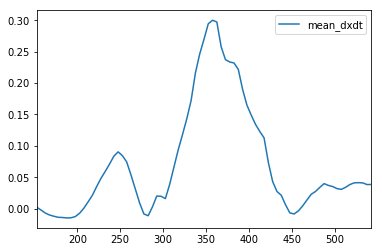

In [13]:
df_pd.groupby('y')['u'].mean().to_frame(name='mean_dxdt').set_index(y_idx.mid).plot()

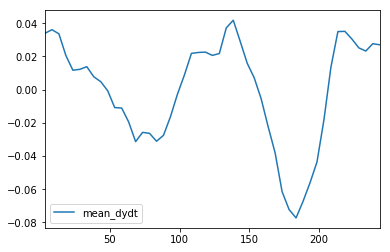

In [21]:
df_pd.groupby('x')['v'].mean().to_frame(name='mean_dydt').set_index(x_idx.mid).plot()

In [24]:
U2 = (df_pd['u'])**2
V2 = (df_pd['v'])**2


In [35]:
df_pd.groupby('x')['v'].mean()

x
(1.0, 6.0]        0.033939
(6.0, 11.0]       0.036125
(11.0, 16.0]      0.033641
(16.0, 21.0]      0.020593
(21.0, 26.0]      0.011718
(26.0, 31.0]      0.012246
(31.0, 36.0]      0.013831
(36.0, 41.0]      0.007766
(41.0, 46.0]      0.004803
(46.0, 51.0]     -0.000689
(51.0, 56.0]     -0.010795
(56.0, 61.0]     -0.011064
(61.0, 66.0]     -0.019438
(66.0, 71.0]     -0.031318
(71.0, 76.0]     -0.025729
(76.0, 81.0]     -0.026338
(81.0, 86.0]     -0.031091
(86.0, 91.0]     -0.027481
(91.0, 96.0]     -0.016207
(96.0, 101.0]    -0.002682
(101.0, 106.0]    0.008901
(106.0, 111.0]    0.021847
(111.0, 116.0]    0.022402
(116.0, 121.0]    0.022614
(121.0, 126.0]    0.020643
(126.0, 131.0]    0.021761
(131.0, 136.0]    0.037234
(136.0, 141.0]    0.041816
(141.0, 146.0]    0.028987
(146.0, 151.0]    0.015903
(151.0, 156.0]    0.007141
(156.0, 161.0]   -0.005525
(161.0, 166.0]   -0.022317
(166.0, 171.0]   -0.038101
(171.0, 176.0]   -0.061461
(176.0, 181.0]   -0.072227
(181.0, 186.0]   -0.077270

In [25]:
V2.groupby('x').mean().to_frame(name='mean_dydt').set_index(x_idx.mid).plot()

KeyError: 'x'

## Déplacement des flotteurs

In [7]:
flt_t0 = df.groupby('time').get_group(1500.0069).compute().sort_values('id').set_index(['id'])

In [8]:
x0 = np.arange(flt_t0.index.min(),flt_t0.index.max(),5)
         #np.arange(flt_t0.ygrid.min(),flt_t0.ygrid.max(),5)]

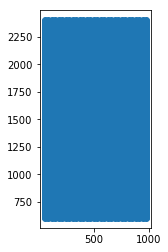

In [11]:
fig,ax=plt.subplots()
ax.scatter(flt_t0.x,flt_t0.y)
ax.set_aspect('equal')

In [35]:
flt_t0.x[flt_t0.x.diff()>1].diff()

id
301           NaN
601     31.895048
901     31.893688
1201    31.892592
1501    31.892168
1801    31.891812
2101    31.891888
2401    31.891932
2701    31.892300
3001    31.892568
3301    31.893380
3601    31.894080
3901    31.895280
4201    31.896280
4501    31.897120
4801    31.897320
5101    31.897320
5401    31.897080
5701    31.897240
6001    31.897480
6301    31.898040
6601    31.898560
6901    31.899360
7201    31.899920
7501    31.900560
7801    31.900920
8101    31.901320
8401    31.901080
8701    31.900600
Name: x, dtype: float64

In [43]:
#flt_t0.index.duplicated(keep='first')#.get_loc(50,method='backfill')
#flt_t0.loc[flt_t0.index.min():flt_t0.index.max():5]

array([False, False, False, ..., False, False, False])

In [12]:
indx = np.array([i for i, j in enumerate(flt_t0.xgrid) if j%5<1e-1])

In [19]:
indy = np.array([iy for iy,y in enumerate(flt_t0.ygrid[indx]) if y%5<5e-1])

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [26]:
#indy.isin(ind)
#print(flt_t0.index[ind], ind)
print(indx.size,indy.size)

230 27


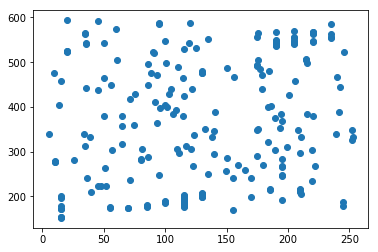

In [15]:
plt.scatter(flt_t0.xgrid[indx],flt_t0.ygrid[indx])

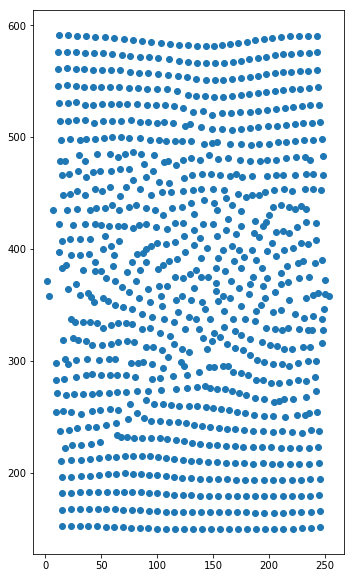

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(flt_t0.iloc[0:-1:10].xgrid,flt_t0.iloc[0:-1:10].ygrid)
ax.set_aspect('equal')

In [37]:
id0=flt_t0.iloc[0:-1:30].index

In [14]:
id0

Int64Index([   1,   31,   61,   91,  121,  151,  181,  211,  241,  271,
            ...
            8701, 8731, 8761, 8791, 8821, 8851, 8881, 8911, 8941, 8971],
           dtype='int64', name='id', length=300)

In [42]:
dfi = df.compute().sort_values('id').set_index('id').loc[id0]

KilledWorker: ("('from-delayed-pandas_read_text-read-block-assign-6912bd4bb8416d1c0e2f02ff9d5a7c55', 225)", <Worker 'tcp://127.0.0.1:55662', memory: 0, processing: 349>)

In [24]:
dfi1 = df_pd1.sort_values('id').set_index('id').loc[id0]

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [17]:
dfi2 = df_pd2.sort_values('id').set_index('id').loc[id0]

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [14]:
dfi3 = df_pd3.sort_values('id').set_index('id').loc[id0]

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [38]:
dfi4 = df_pd4.sort_values('id').set_index('id').loc[id0]

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [20]:
Y0 = dfi[dfi.time==1501].ygrid


In [160]:
test = dfi[dfi.time==1501].assign(y_0=Y0)

In [161]:
test

,time,xgrid,ygrid,zgrid,depth,temp,X1,X2,X3,X4,X5,y_0
id,,,,,,,,,,,,
1,1501.0,15.002721,152.06570,50.0,0.553202,24.579828,0.093296,0.078887,-2.843551e-08,1.364204e-07,6.302027,152.06570
31,1501.0,14.957614,196.07894,50.0,0.398125,24.583169,0.094882,0.036101,4.242617e-08,3.107780e-07,4.780808,196.07894
61,1501.0,13.108027,237.26999,50.0,0.219845,24.714261,0.035972,-0.147643,-4.785455e-07,7.520620e-07,3.036488,237.26999
91,1501.0,9.282737,283.09136,50.0,0.469308,24.665004,-0.158569,-0.126536,-6.124482e-08,-1.915536e-07,5.481979,283.09136
121,1501.0,23.169503,337.46731,50.0,0.428183,24.749128,0.504061,0.370894,-2.480141e-07,-1.950424e-07,5.081526,337.46731
...,...,...,...,...,...,...,...,...,...,...,...,...
8851,1501.0,1.898898,371.31634,50.0,-0.599193,25.410876,0.627327,-0.197452,-8.727107e-08,1.496200e-06,-4.974289,371.31634
8881,1501.0,241.537570,422.92989,50.0,-0.721126,25.811939,-0.138308,0.067068,4.032240e-07,-1.215838e-07,-6.155494,422.92989
8911,1501.0,248.017280,465.64265,50.0,-0.614214,25.540927,0.158827,-0.029749,-9.065893e-07,1.357674e-07,-5.117010,465.64265


In [26]:
idn = np.where(id0.isin(dfi[dfi.time==1600].index)==True)[0]

In [22]:
Y0[Y0.index.isin(id0[idn])].size

289

In [28]:
I = np.arange(1501,1511,1)    

In [27]:
Y0.loc[id0]

id
1       152.06570
31      196.07894
61      237.26999
91      283.09136
121     337.46731
          ...    
8851    371.31634
8881    422.92989
8911    465.64265
8941    513.19526
8971    559.67023
Name: ygrid, Length: 300, dtype: float64

In [25]:
figdir='/home1/datahome/zcaspar/figs/'
for i in I:
    figname = figdir+'flt_t%05d'%i + '.png'
    dft = dfi[dfi.time==i]
    #dft = dft.assign(y0 = Y0)
    non_id = np.where(id0.isin(dft.index)==True)[0]
    #dfg = dft[dft.index.isin(id0[idn])]
    fig,ax = plt.subplots(figsize=(10,10))
    #if non_id.size==0:
    cs = ax.scatter(dft.xgrid,dft.ygrid,c=Y0[Y0.index.isin(id0[non_id])],cmap='jet')
    #if non_id.size!=0:
    #    cs = ax.scatter(dft[dfi.index!=id0[non_id]].xgrid,dfi[dfi.time==i & dfi.index!=id0[non_id]].ygrid
    #                    ,c=Y0[dfi.index!=id0[non_id]],cmap='jet')
    ax.set_aspect('equal')
    ax.set_xlabel('x'),ax.set_ylabel('y')
    fig.colorbar(cs,label='Latitude at t0 = 1501days')
    ax.set_title(r'$Time\simeq%s$days'%int(i))
    ax.set_ylim(100,650);ax.set_xlim(0,260)
    fig.savefig(figname)
    plt.close()

In [29]:
I = np.arange(1601,1701,1)    

In [15]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=['surf'], 
                chunk_time={'his': 1, 'surf': 1}, grid_params=gparams)

In [16]:
ds = r['surf']

In [17]:
ds = ds.assign_coords(time=ds.time_counter)

In [33]:
ds.time

<xarray.DataArray 'time' (time: 72000)>
array([1500.003472, 1500.010417, 1500.017361, ..., 1999.982639, 1999.989583,
       1999.996528])
Coordinates:
    time_instant  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
  * time          (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03

In [18]:
figdir='/home1/scratch/zcaspar/figs/'

In [67]:
I = np.arange(1501,1601,1)
for i in I:
    figname = figdir+'fltu_t%05d'%i + '.png'
    dft = dfi[dfi.time==i]
    #dft = dft.assign(y0 = Y0)
    non_id = np.where(id0.isin(dft.index)==True)[0]
    #dfg = dft[dft.index.isin(id0[idn])]
    fig,ax = plt.subplots(figsize=(10,10))
    #if non_id.size==0:
    ds.u.sel(time=i,s_rho_slice0=0,method='nearest').plot(ax=ax)
    cs = ax.scatter(dft.xgrid,dft.ygrid,c=Y0[Y0.index.isin(id0[non_id])],cmap='jet')
    #if non_id.size!=0:
    #    cs = ax.scatter(dft[dfi.index!=id0[non_id]].xgrid,dfi[dfi.time==i & dfi.index!=id0[non_id]].ygrid
    #                    ,c=Y0[dfi.index!=id0[non_id]],cmap='jet')
    
    ax.set_aspect('equal')
    ax.set_xlabel('x'),ax.set_ylabel('y')
    fig.colorbar(cs,label='Latitude at t0 = 1501days')
    ax.set_title(r'$Time\simeq%s$days'%int(i))
    #ax.set_ylim(100,650);ax.set_xlim(0,260)
    fig.savefig(figname)
    plt.close()

In [36]:
I1 = np.arange(1601,1701,1)
for i in I1:
    figname = figdir+'fltu_t%05d'%i + '.png'
    dft = dfi1[dfi1.time==i]
    #dft = dft.assign(y0 = Y0)
    non_id = np.where(id0.isin(dft.index)==True)[0]
    #dfg = dft[dft.index.isin(id0[idn])]
    fig,ax = plt.subplots(figsize=(10,10))
    #if non_id.size==0:
    ds.u.sel(time=i,s_rho_slice0=0,method='nearest').plot(ax=ax)
    cs = ax.scatter(dft.xgrid,dft.ygrid,c=Y0[Y0.index.isin(id0[non_id])],cmap='jet')
    #if non_id.size!=0:
    #    cs = ax.scatter(dft[dfi.index!=id0[non_id]].xgrid,dfi[dfi.time==i & dfi.index!=id0[non_id]].ygrid
    #                    ,c=Y0[dfi.index!=id0[non_id]],cmap='jet')
    
    ax.set_aspect('equal')
    ax.set_xlabel('x'),ax.set_ylabel('y')
    fig.colorbar(cs,label='Latitude at t0 = 1501days')
    ax.set_title(r'$Time\simeq%s$days'%int(i))
    #ax.set_ylim(100,650);ax.set_xlim(0,260)
    fig.savefig(figname)
    plt.close()

In [60]:
I2 = np.arange(1701,1801,1)
for i in I2:
    figname = figdir+'fltu_t%05d'%i + '.png'
    dft = dfi2[dfi2.time==i]
    #dft = dft.assign(y0 = Y0)
    non_id = np.where(id0.isin(dft.index)==True)[0]
    #dfg = dft[dft.index.isin(id0[idn])]
    fig,ax = plt.subplots(figsize=(10,10))
    #if non_id.size==0:
    ds.u.sel(time=i,s_rho_slice0=0,method='nearest').plot(ax=ax)
    cs = ax.scatter(dft.xgrid.unique(),dft.ygrid.unique(),c=Y0[Y0.index.isin(id0[non_id])],cmap='jet')
    #if non_id.size!=0:
    #    cs = ax.scatter(dft[dfi.index!=id0[non_id]].xgrid,dfi[dfi.time==i & dfi.index!=id0[non_id]].ygrid
    #                    ,c=Y0[dfi.index!=id0[non_id]],cmap='jet')
    
    ax.set_aspect('equal')
    ax.set_xlabel('x'),ax.set_ylabel('y')
    fig.colorbar(cs,label='Latitude at t0 = 1501days')
    ax.set_title(r'$Time\simeq%s$days'%int(i))
    #ax.set_ylim(100,650);ax.set_xlim(0,260)
    fig.savefig(figname)
    plt.close()

In [28]:
I3 = np.arange(1801,1901,1)
for i in I3:
    figname = figdir+'fltu_t%05d'%i + '.png'
    dft = dfi3[dfi3.time==i]
    #dft = dft.assign(y0 = Y0)
    non_id = np.where(id0.isin(dft.index)==True)[0]
    #dfg = dft[dft.index.isin(id0[idn])]
    fig,ax = plt.subplots(figsize=(10,10))
    #if non_id.size==0:
    ds.u.sel(time=i,s_rho_slice0=0,method='nearest').plot(ax=ax)
    cs = ax.scatter(dft.xgrid,dft.ygrid,c=Y0[Y0.index.isin(id0[non_id])],cmap='jet')
    #if non_id.size!=0:
    #    cs = ax.scatter(dft[dfi.index!=id0[non_id]].xgrid,dfi[dfi.time==i & dfi.index!=id0[non_id]].ygrid
    #                    ,c=Y0[dfi.index!=id0[non_id]],cmap='jet')
    
    ax.set_aspect('equal')
    ax.set_xlabel('x'),ax.set_ylabel('y')
    fig.colorbar(cs,label='Latitude at t0 = 1501days')
    ax.set_title(r'$Time\simeq%s$days'%int(i))
    #ax.set_ylim(100,650);ax.set_xlim(0,260)
    fig.savefig(figname)
    plt.close()

In [39]:
I4 = np.arange(1901,2001,1)
for i in I4:
    figname = figdir+'fltu_t%05d'%i + '.png'
    dft = dfi4[dfi4.time==i]
    #dft = dft.assign(y0 = Y0)
    non_id = np.where(id0.isin(dft.index)==True)[0]
    #dfg = dft[dft.index.isin(id0[idn])]
    fig,ax = plt.subplots(figsize=(10,10))
    #if non_id.size==0:
    ds.u.sel(time=i,s_rho_slice0=0,method='nearest').plot(ax=ax)
    cs = ax.scatter(dft.xgrid,dft.ygrid,c=Y0[Y0.index.isin(id0[non_id])],cmap='jet')
    #if non_id.size!=0:
    #    cs = ax.scatter(dft[dfi.index!=id0[non_id]].xgrid,dfi[dfi.time==i & dfi.index!=id0[non_id]].ygrid
    #                    ,c=Y0[dfi.index!=id0[non_id]],cmap='jet')
    
    ax.set_aspect('equal')
    ax.set_xlabel('x'),ax.set_ylabel('y')
    fig.colorbar(cs,label='Latitude at t0 = 1501days')
    ax.set_title(r'$Time\simeq%s$days'%int(i))
    #ax.set_ylim(100,650);ax.set_xlim(0,260)
    fig.savefig(figname)
    plt.close()

In [27]:
dfi3[dfi3.time==i].ygrid

id
31      271.03992
61      278.78334
91      345.43230
121     433.83838
151     350.84766
          ...    
6961    248.01612
6991    262.22078
7021    274.13900
7051    336.07341
7081    394.29832
Name: ygrid, Length: 208, dtype: float64

In [59]:
#dfi2[dfi2.time==i]
Y0[Y0.index.isin(id0[non_id])].index
#id0
dfi2[dfi2.time==i].xgrid.unique()#[dfi2[dfi2.time==i].index.unique()]#.index.unique()#[dfi2[dfi2.time==i].index.isin(id0[non_id])]


array([242.70937  ,  75.926307 , 111.57082  ,  34.391586 ,  56.757206 ,
       158.8687   ,  45.505254 , 115.24501  , 193.81227  ,  56.89202  ,
       222.91463  , 132.23475  , 169.43631  ,  43.784933 , 244.12688  ,
        98.111482 , 219.52173  , 127.41063  , 227.59795  ,  64.611083 ,
       217.27503  , 201.57941  ,  46.376291 , 225.53481  ,  42.668183 ,
         7.5234088, 175.25203  , 126.30858  , 176.22114  ,  66.682129 ,
        60.861824 ,  51.613348 ,  36.258685 ,  18.56212  , 183.03484  ,
       109.0285   , 133.25031  , 146.88342  , 139.1722   ,  66.485012 ,
        80.59636  ,   5.760068 , 244.75576  ,  85.822965 ,  91.132855 ,
        25.571268 , 208.83771  , 136.48103  ,  68.58873  , 147.24102  ,
        36.830367 , 238.12297  ,  60.341118 , 166.82618  ,  63.3377   ,
        37.268722 , 200.22615  , 175.21394  ,  75.153726 , 143.06964  ,
       191.81201  ,  26.475317 , 171.2219   ,  17.835407 ,  35.295394 ,
        25.640828 , 148.64589  , 155.16563  ,  84.5351   , 147.9

Int64Index([  31,   61,   91,  121,  151,  181,  211,  241,  271,  301,
            ...
            7651, 7711, 7741, 7771, 7801, 7831, 7861, 7891, 7921, 7951],
           dtype='int64', name='id', length=246)

In [40]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", line 1290, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", line 1019, in _reconnect
    await self._close()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", l